# Recommendations with IBM

In this notebook, recommendation engines are created using real data from the IBM Watson Studio platform.<br> The goal is to recommend users appropriate articles they would be interested in.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [263]:
# Download nltk packages
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Import custom tokenize function from tokenize_mod
from tokenize_mod import tokenize

%matplotlib inline

# Read in data as csv
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Switch dtype of article id to float
df_content['article_id'] = df_content['article_id'].astype(float)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Savo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Savo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Savo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Savo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [264]:
# Show df, which includes user-article interactions while users are identified by an email.
df.head(5)

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [265]:
# This data includes "unique" values for each article. Its a deep dive into each article.
df_content.head(5)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0.0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1.0
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2.0
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3.0
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4.0


Let us have a look at some values to describe the data, sorted by users and by articles

In [266]:
print(f"Distribution of Article Views per User: \n\n{article_views_usr.describe().round(1)} \n\n")
print(f"Distribution of Article Views per Article: \n\n{article_views_art.describe().round(1)}")

Distribution of Article Views per User: 

count    5148.0
mean        8.9
std        16.8
min         1.0
25%         1.0
50%         3.0
75%         9.0
max       364.0
Name: count, dtype: float64 


Distribution of Article Views per Article: 

count    714.0
mean      64.4
std      109.2
min        1.0
25%        8.0
50%       25.0
75%       69.0
max      937.0
Name: count, dtype: float64


In [267]:
# Number of total interactions:
print("Number of total user-to-article interactions: ", df.shape[0], "\n")

# Number of article interactions per user:
article_views_usr = df.email.value_counts()
print("Number of article interactions per user: ", article_views_usr.head(3), "\n")

# Number of article interactions per article:
article_views_art = df.article_id.value_counts()
print("Number of article interactions per article: ", article_views_art.head(3), "\n")

# Number of unique users:
usr_unq = df.email.nunique()
print("Number of unique users: ", usr_unq, "\n")

# Max view counts of users per article:
art_views_unq_usr = df.groupby(['email', 'article_id']).size().reset_index(name='view_count')
art_views_unq_usr = art_views_unq_usr.sort_values(by='view_count', ascending=False)
art_views_unq_usr
print("Views of users per same article: ", art_views_unq_usr.head(3), "\n")

Number of total user-to-article interactions:  45993 

Number of article interactions per user:  email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
Name: count, dtype: int64 

Number of article interactions per article:  article_id
1429.0    937
1330.0    927
1431.0    671
Name: count, dtype: int64 

Number of unique users:  5148 

Views of users per same article:                                           email  article_id  view_count
3074  1588af175b283915f597fc4719cbb2c8621c4fc2      1170.0          42
7405  363cb98a087e4a3eb6890fd1af2d418116f85ff8      1170.0          41
5958  2b6c0f514c2f2b04ad3c4583407dccd0810469ee      1429.0          35 



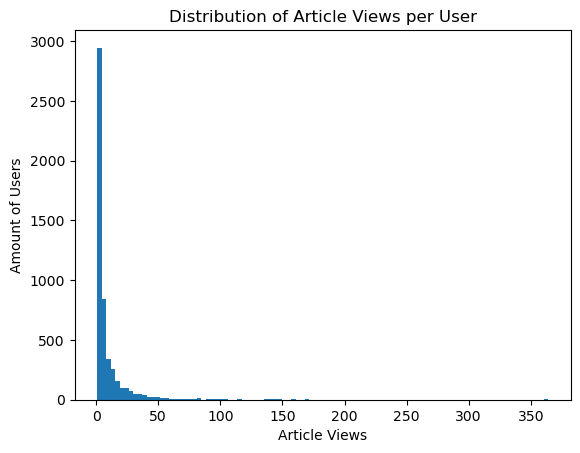

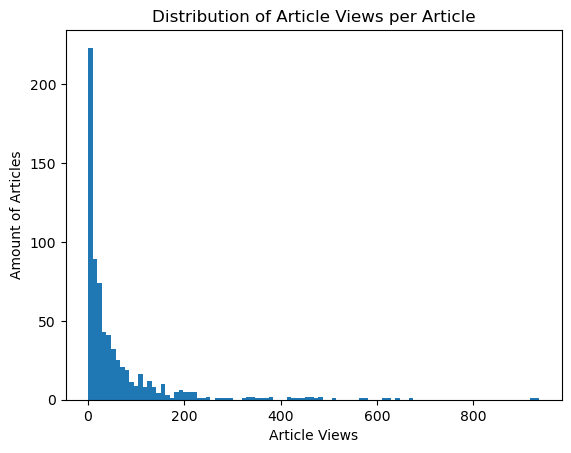

In [268]:
# Create a histogram of article view distribution per user and article
plt.hist(article_views_usr, bins=100)
plt.xlabel('Article Views')
plt.ylabel('Amount of Users')
plt.title('Distribution of Article Views per User')
plt.show()
plt.hist(article_views_art, bins=100)
plt.xlabel('Article Views')
plt.ylabel('Amount of Articles')
plt.title('Distribution of Article Views per Article')
plt.show()

In order to see whether there are values in df that don't exist in df_content we will write a function and apply it to the two dfs.

In [269]:
# Function to find the articles that are present in df but not in df_content
def find_missing_articles(df, df_content):
    """
    This function checks if there are any article_ids in df that are not in df_content.
    
    Args:
    df (DataFrame): The main DataFrame with article interactions.
    df_content (DataFrame): The DataFrame containing article metadata.
    
    Returns:
    missing_article_ids (list): A list of article_ids in df that are not present in df_content.
    """
    # Convert article_id columns to string to avoid data type mismatch
    df['article_id'] = df['article_id'].astype(str)
    df_content['article_id'] = df_content['article_id'].astype(str)

    # Find article_ids in df that are not in df_content
    missing_article_ids = df[~df['article_id'].isin(df_content['article_id'])]['article_id'].unique()

    # Return the list of missing article_ids
    return missing_article_ids

In [270]:
# Find the miussing articles and count how many there are
missing_articles = find_missing_articles(df, df_content)
print("Amount of missing values that exist in df but not in df_content is: " + str(len(find_missing_articles(df, df_content))))

Amount of missing values that exist in df but not in df_content is: 277


In [271]:
median_val = article_views_usr.median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = article_views_usr.max() # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [272]:
# Find and explore duplicate articles
df_content_duplicates = df_content[df_content['article_id'].duplicated()]
df_content_duplicates.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50.0
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221.0
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398.0
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577.0
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232.0


In [273]:
# Remove any rows that have the same article_id - only keep the first
df_new = df_content.drop_duplicates(subset="article_id")
df_new.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [274]:
#a.) Number of articles with user interaction
print(df.article_id.nunique())

#b.) Number of all articles (no matter if user interaction or not)
print(df_content.article_id.nunique())

#c.) The number of unique users in the dataset. (excluding null values)
print(usr_unq)

#d.)
print(df.shape[0])

714
1051
5148
45993


In [275]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [276]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(article_views_art.idxmax())

#max_views = # The most viewed article in the dataset was viewed how many times?
max_views = article_views_art.max()

In [277]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [278]:
# Check the results

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [279]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Use the get_top_article_ids function to retrieve ids of n top articles
    top_articles_id = get_top_article_ids(n, df)
    
    # Use ids to get the title of n top articles
    top_articles = df[df['article_id'].isin(top_articles_id)][['article_id', 'title']].drop_duplicates()["title"].tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    #  get the views per article from df
    article_views_art = df.article_id.value_counts()
    
    # get the n top viewed articles ids
    top_articles = list(map(str, article_views_art.head(n).index.tolist()))
 
    return top_articles # Return the top article ids

In [280]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [281]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [282]:
df.head(3)

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3


In [283]:
# Create a pivot table from dfs user_id and article_id columns where 1s indicate an entry and 0 not
df_new = df[['user_id', 'article_id']].pivot_table(index='user_id', columns='article_id', aggfunc=lambda x: 1, fill_value=0)
df_new.head(3)

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [284]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df[['user_id', 'article_id']].pivot_table(index='user_id', columns='article_id', aggfunc=lambda x: 1, fill_value=0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [285]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [286]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''  
    # Calculate the dot product between the chosen vector for user_id and the total matrix to check for similarity
    user_vec = user_item.loc[user_id].values
    dot_products = np.dot(user_item.values, user_vec)
    
    # Convert the result to a pandas Series for easier interpretation
    similarity_series = pd.Series(dot_products, index=df_new.index)
    #print(similarity_series)

    # Sort the similarity scores in descending order (most similar users first)
    sorted_similarity = similarity_series.sort_values(ascending=False)
    #print(sorted_similarity)
    
    # remove the own user's id
    sorted_similarity = sorted_similarity.drop(user_id)

    # create list of just the ids
    most_similar_users = sorted_similarity.index.tolist()
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [287]:
#find_similar_users(1)

In [288]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [289]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Get the article IDs for the user, where interaction is 1
    article_ids = user_item.columns[user_item.iloc[user_id-1] == 1].astype(str).tolist()
    
    # Get the article names using the article IDs
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Find similar users
    similar_users = find_similar_users(user_id, user_item=user_item)
    
    # Get the articles the user has already seen
    user_article_ids, _ = get_user_articles(user_id, user_item=user_item)
    
    recs = []
    
    # Loop through similar users and get articles
    for user in similar_users:
        sim_user_article_ids, _ = get_user_articles(user, user_item=user_item)
        
        # Add only the articles the user hasn't seen yet
        for article_id in sim_user_article_ids:
            if article_id not in user_article_ids and article_id not in recs:
                recs.append(article_id)
                
            # Stop once we have enough recommendations
            if len(recs) >= m:
                return recs  # Return exactly `m` recommendations
        if len(recs) >= m:
            break
    
    return recs # return your recommendations for this user_id    

In [290]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

In [291]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [292]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [293]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # Compute similarity using dot product
    user_vec = user_item.loc[user_id].values
    dot_products = np.dot(user_item.values, user_vec)
    
    # Create a pandas DataFrame for similarity scores
    similarity_df = pd.DataFrame({'neighbor_id': user_item.index,'similarity': dot_products})
    
    # Remove the input user from the results
    similarity_df = similarity_df[similarity_df['neighbor_id'] != user_id]
    
    # Calculate the number of interactions per user (sum of 1's in the user_item matrix rows)
    num_interactions = user_item.sum(axis=1)
    
    # Add the number of total interactions per user to the corresponding ids in the df
    similarity_df['num_interactions'] = num_interactions.loc[similarity_df['neighbor_id']].values
    
    # Sort by similarity first, then by num_interactions
    neighbors_df = similarity_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    # Get the most similar users
    similar_users_df = get_top_sorted_users(user_id, df, user_item)
    
    # Get the articles the user has already seen
    user_article_ids, _ = get_user_articles(user_id, user_item=user_item)
    
    recs = []
    rec_names = []
    
    # For each similar user, find articles they have interacted with that the user hasn't seen yet
    for neighbor_id in similar_users_df['neighbor_id']:
        
        # Get articles the similar user has interacted with
        sim_user_article_ids = user_item.loc[neighbor_id][user_item.loc[neighbor_id] == 1].index.tolist()
        
        # Filter articles that the user has not seen and haven't been recommended yet
        new_recs = [article_id for article_id in sim_user_article_ids if article_id not in user_article_ids and article_id not in recs]
        
        # Rank new articles by total interactions in the dataset
        article_interactions = df['article_id'].value_counts()
        new_recs = sorted(new_recs, key=lambda x: article_interactions.get(x, 0), reverse=True)
        
        # Add new recommendations to list
        recs.extend(new_recs)
        
        # Stop if we have enough recommendations m
        if len(recs) >= m:
            break
    
    # Get the article names for the recommended articles
    rec_names = df[df['article_id'].isin(recs[:m])]['title'].unique().tolist()
    
    return recs, rec_names

In [294]:
get_top_sorted_users(1, df=df, user_item=user_item).head(10)

,neighbor_id,similarity,num_interactions
3932,3933,35,35
22,23,17,135
3781,3782,17,135
202,203,15,96
4458,4459,15,96
130,131,14,75
3869,3870,14,75
45,46,13,40
4200,4201,13,40
48,49,12,101


In [295]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1330.0', '1314.0', '1293.0', '1162.0', '1271.0', '43.0', '1351.0', '1368.0', '1305.0', '1338.0', '1336.0', '1172.0', '151.0', '1276.0', '1432.0', '390.0', '1164.0', '1332.0', '1396.0', '109.0', '237.0', '1367.0', '1422.0', '12.0', '415.0', '162.0', '1186.0', '730.0', '33.0', '939.0', '981.0', '51.0', '1357.0', '1014.0', '221.0', '933.0', '880.0', '316.0', '14.0', '153.0', '29.0', '379.0', '111.0', '692.0', '1059.0', '315.0', '464.0', '761.0', '130.0', '547.0', '491.0', '253.0', '607.0', '967.0', '382.0', '609.0', '1157.0', '142.0', '813.0', '244.0', '302.0', '858.0', '990.0', '273.0', '347.0', '468.0', '876.0', '857.0', '763.0']

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'use deep learning for image classification', 'analyze energy consumption in buildings', 'putting a human face on machine learning', 'gosales transactions for 

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [296]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1, df=df, user_item=user_item) # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item) # Find the 10th most similar user to user 131

In [297]:
### Tests with a dictionary of results
user1_most_sim = user1_most_sim["neighbor_id"].values[0] # Find the user that is most similar to user 1 
user131_10th_sim = user131_10th_sim["neighbor_id"].values[10] # Find the 10th most similar user to user 131

In [298]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**New users will be recommended the mopst popular articles through the get_top_articles and get_top_article ids function. A better way would be to have useres select categories they are interested in when first registering to the plattform. Based on the feedback, more personalized recommendations could be given.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [299]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [300]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` the build_similarity_model()

Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [301]:
def build_similarity_model(df_content):
    """
    Builds a content-based similarity model using TF-IDF and cosine similarity.
    
    The function performs the following steps:
    1. Vectorizes the document titles using TF-IDF.
    2. Computes the cosine similarity matrix between document titles.
    
    Returns:
    --------
    cosine_sim_df: DataFrame
        A DataFrame containing the cosine similarity scores between document titles.
    """

    # Extract document titles from the df
    doc_name = df_content['doc_full_name'].values.tolist()

    # Create a TF-IDF vectorizer and fit it to the document titles
    vectorizer = TfidfVectorizer(tokenizer=tokenize, min_df=2, max_df=0.95, token_pattern=None)
    X = vectorizer.fit_transform(doc_name)

    # Compute the cosine similarity matrix between all document vectors
    cosine_sim = cosine_similarity(X)

    # Convert the similarity matrix into a df
    cosine_sim_df = pd.DataFrame(cosine_sim, index=doc_name, columns=doc_name)

    # Return the cosine similarity DataFrame
    return cosine_sim_df

In [302]:
def content_based_recc(user_id, m=10, missing_articles=missing_articles):
    """
    Recommend m most similar articles to the most popular article the user has interacted with,
    excluding articles that are missing from df_content. Outputs both article_id and doc_full_name.
    
    Args:
    user_id (int): The ID of the user for whom recommendations are being made.
    m (int): The number of recommendations to generate. Default is 10.
    missing_articles (list): A list of article_ids that should be excluded from the recommendations.
    
    Returns:
    list: A list of recommended articles in the form of tuples (article_id, doc_full_name).
    """
    
    # Get article ids of the articles the user has seen
    article_ids_seen, _ = get_user_articles(user_id, user_item=user_item)

    # Filter the articles seen by the user, excluding missing articles in df_content
    articles_seen = df[df['article_id'].astype(str).isin(article_ids_seen) & 
                       ~df['article_id'].astype(str).isin(missing_articles)]

    # Check if any articles are left after filtering
    if articles_seen.empty:
        print(f"User {user_id} has not seen any valid articles (excluding missing ones).")
        return []

    # Rank articles seen by the user by the number of interactions
    article_interactions = articles_seen['article_id'].value_counts()
    article_id_nr_1 = article_interactions.idxmax()

    # Get the article name of the most interacted article
    article_name_nr_1 = df_content[df_content['article_id'] == article_id_nr_1]['doc_full_name'].values[0]

    # Print user id and the article chosen for similarity comparison
    print(f"Recommendations for User ID: {user_id}")
    print(f"Article used for similarity comparison (most interacted by user):")
    print(f"  - Article ID: {article_id_nr_1}, Article Name: {article_name_nr_1}")
    
    # Get the cosine similarity DataFrame using the build_similarity_model() function
    cosine_sim_df = build_similarity_model(df_content)  # Assuming cosine_sim_df is built globally or from another source

    # Find the most similar articles to the most popular one
    sorted_similarity_scores = cosine_sim_df.loc[article_name_nr_1].sort_values(ascending=False)

    # Drop the chosen article_id article from the list to avoid recommending the same article
    sorted_similarity_scores = sorted_similarity_scores.drop(article_name_nr_1)

    # Filter articles that the user has not seen, not missing, and take the top m recommendations
    recommendations = []
    
    for similar_article_name in sorted_similarity_scores.index:
        similar_article_id = df_content[df_content['doc_full_name'] == similar_article_name]['article_id'].values[0]

        # Only recommend articles that the user has not seen and are not in missing_articles
        if similar_article_id not in article_ids_seen and similar_article_id not in missing_articles:
            recommendations.append((similar_article_id, similar_article_name))

        # Stop when we have enough recommendations
        if len(recommendations) >= m:
            break

    # Output the recommended articles
    print("\nRecommended Articles:")
    for article_id, article_name in recommendations:
        print(f"  - Article ID: {article_id}, Article Name: {article_name}")
    
    return recommendations

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

<h3>Summary of Content-Based Recommendation Function:</h3>

<ol>
    <li>Create <code>build_similary_model</code> to estimate similar articles to a chosen article:
        <ol type="a">
            <li>Create a TF-IDF vectorizer and fit it to the document titles using a customized tokenize function.</li>
            <li>Compute the cosine similarity matrix between all document vectors and return the cosine similarity DataFrame.</li>
        </ol>
    </li>
    <li>Create the main <code>content_based_recc</code> function to return content-based recommendations:
        <ol>
            <li>Get the article ids that the user has seen, which are in <code>df_content</code>, and rank them based on interactions.</li>
            <li>Take the article with the most interactions and find the <code>m</code> most similar articles to the chosen one via the cosine similarity matrix.</li>
            <li>Only add articles the user has not seen and do this as long as <code>m</code> articles are recommended.</li>
        </ol>
    </li>
</ol>

<h4>Further Improvements:</h4>
<ul>
    <li>Choosing only the most viewed article that the user has seen is not the best method, as the user might have seen that article a long time ago. Choosing the most recent article the user has clicked on would be more appropriate. Unfortunately, no time data was given in the provided data frames.</li>
</ul>

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.

In [303]:
# Make a recommendations for a user
content_based_recc = content_based_recc(1320,10)

Recommendations for User ID: 1320
Article used for similarity comparison (most interacted by user):
  - Article ID: 887.0, Article Name: Forgetting the Past to Learn the Future: Long Short-Term Memory Neural Networks for Time Series Prediction

Recommended Articles:
  - Article ID: 310.0, Article Name: Time Series Prediction Using Recurrent Neural Networks (LSTMs)
  - Article ID: 303.0, Article Name: Backpropagation — How Neural Networks Learn Complex Behaviors
  - Article ID: 204.0, Article Name: Charity Majors on Observability & The Glorious Future
  - Article ID: 785.0, Article Name: Interactive time series with dygraphs
  - Article ID: 862.0, Article Name: Time Series Analysis Using Max/Min and Neuroscience
  - Article ID: 465.0, Article Name: Introduction to Neural Networks, Advantages and Applications
  - Article ID: 813.0, Article Name: Generative Adversarial Networks (GANs)
  - Article ID: 291.0, Article Name: A guide to receptive field arithmetic for Convolutional Neural Netwo

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [304]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [305]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [306]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True) # use the built in to get the three matrices

**We can use the standard SVD-approach as there are no NaN-values in the Matrix. Otherwise we would have to switch to appropriate models to deal with that like SVDFunk**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


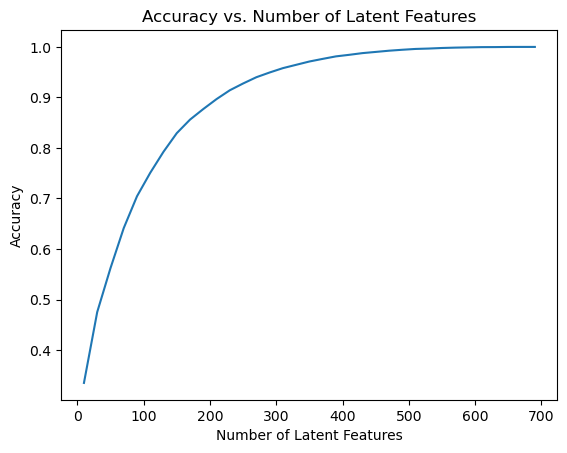

In [307]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [308]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [309]:
print(u_test.shape, vt_test.shape)

(20, 4487) (714, 574)


In [310]:
# Test predictable users
test_predictable_usr = np.intersect1d(test_idx, train_idx)
n_test_pred = len(test_predictable_usr)
print(n_test_pred)

# Test not predictable users
n_test_not_pred_usr = len(test_idx) - n_test_pred
print(n_test_not_pred_usr)

# Test predictable articles
test_predictable_arts = np.intersect1d(test_arts, train_arts)
n_test_pred = len(test_predictable_arts)
print(n_test_pred)

# Test not predictable articles
n_test_not_pred_arts = len(test_arts) - n_test_pred
print(n_test_not_pred_arts)

20
662
574
0


In [311]:
# Subset the train and test matrices to only predictable users and articles
u_test = user_item_train.loc[test_predictable_usr, :]
vt_test = user_item_train.loc[:, test_predictable_arts]

user_item_test_mat = user_item_test.loc[test_predictable_usr, test_predictable_arts]

In [312]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [313]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) 
# Shape of u_train, s_train and vt_train
print(u_train.shape, s_train.shape, vt_train.shape)

(4487, 4487) (714,) (714, 714)


In [318]:
# Find users common to both train and test sets
common_user_ids = user_item_test.index.intersection(user_item_train.index)

# Filter test and train matrices to include only common users and articles
user_item_test_red = user_item_test.loc[common_user_ids]
u_test = u_train[user_item_train.index.get_indexer(common_user_ids), :]
vt_test = vt_train[:, user_item_train.columns.isin(user_item_test.columns)]

# Display the shapes of the filtered matrices
print(u_test.shape, vt_test.shape)

(20, 4487) (714, 574)


In [315]:
# Go to the max of latent features by using the shape of u_train and vt_train
max_latent_feats = min(u_train.shape[1], vt_train.shape[0])
num_latent_feats = np.arange(10, max_latent_feats + 10, 20)

sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # Restructure with k latent features for the train and test matrices
    s_new_train, u_new_train, vt_new_train = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]      
    s_new_test, u_new_test, vt_new_test = np.diag(s_train[:k]), u_test[:, :k], vt_test[:k, :]
    
    # Calculatre dot products for each group
    user_item_est_train = np.around(np.dot(np.dot(u_new_train, s_new_train), vt_new_train))
    user_item_est_test = np.around(np.dot(np.dot(u_new_test, s_new_train), vt_new_test))
    
    # Compute difference for train and test data between prediction and actual value
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    diffs_test = np.subtract(user_item_test_red, user_item_est_test)
    
    # Calculate sum of errors for train and test data
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)
    
    # Print latent features and corresponding errors
    print(f"Latent Features: {k}, Train Error: {err_train}, Test Error: {err_test}")

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Latent Features: 10, Train Error: 26542.0, Test Error: 248.0
Latent Features: 30, Train Error: 20886.0, Test Error: 269.0
Latent Features: 50, Train Error: 17312.0, Test Error: 283.0
Latent Features: 70, Train Error: 14149.0, Test Error: 303.0
Latent Features: 90, Train Error: 11642.0, Test Error: 318.0
Latent Features: 110, Train Error: 9745.0, Test Error: 339.0
Latent Features: 130, Train Error: 8068.0, Test Error: 350.0
Latent Features: 150, Train Error: 6735.0, Test Error: 359.0
Latent Features: 170, Train Error: 5678.0, Test Error: 367.0
Latent Features: 190, Train Error: 4767.0, Test Error: 375.0
Latent Features: 210, Train Error: 4017.0, Test Error: 383.0
Latent Features: 230, Train Error: 3350.0, Test Error: 387.0
Latent Features: 250, Train Error: 2752.0, Test Error: 393.0
Latent Features: 270, Train Error: 2285.0, Test Error: 397.0
Latent Features: 290, Train Error: 1908.0, Test Error: 400.0
Latent Features: 310, Train Error: 1603.0, Test Error: 404.0
Latent Features: 330, Tr

<Figure size 640x480 with 0 Axes>

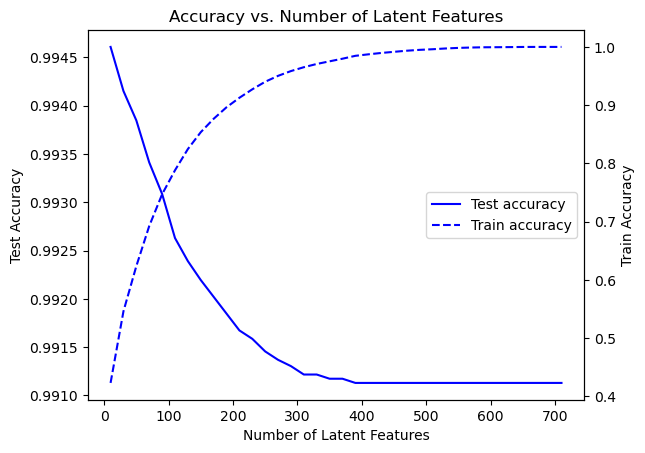

In [316]:
import matplotlib.pyplot as plt

# Clear the plot before drawing new curves
plt.clf()

# Plot your data
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Ensure you're only plotting train and test accuracies
ax1.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df.shape[0], color='blue', linestyle='-', label="Test accuracy")
ax2.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df.shape[0], color='blue', linestyle='--', label="Train accuracy")

# Get handlers and labels for the legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

# Create a combined legend
ax1.legend(h1 + h2, l1 + l2, loc='center right')

# Set axis labels and title
ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('Test Accuracy')
ax2.set_ylabel('Train Accuracy')

plt.title('Accuracy vs. Number of Latent Features')

# Show the plot
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

<h2>Analysis of curves:</h2>
<ul>
    <li><strong>Low Latent Feature Region:</strong> 
        With fewer latent features, the model can't capture the complexity of the data properly, so both train and test accuracies are relatively low. However, the model is not overfitting, and it still generalizes reasonably well to the test data.
    </li>
    <li><strong>High Latent Feature Region:</strong> 
        Beyond a certain point, the model overfits the training data. Train accuracy keeps increasing, but test accuracy declines sharply because the model is learning noise and irrelevant details from the training data. Due to the small size of the test data set, overfitting occurs easily.
    </li>
</ul>

<h2>Possible solutions:</h2>
<p>To resolve the issues of the model, the following steps can be taken:</p>
<ul>
    <li><strong>Collect more data from users in order to increase the test size:</strong>
        <ul>
            <li>This is probably the best way to improve the model. A higher number of users would decrease the variance in test accuracy and provide a more robust model by making it less sensitive to outliers or noise.</li>
            <li>A higher count of different users can help the model learn from more diverse behaviors, reducing the chance of overfitting and increasing its generalization capabilities.</li>
        </ul>
    </li>
    <li><strong>Optimizing the model via early stopping or regularization:</strong>
        <ul>
            <li><strong>Early Stopping:</strong> Instead of using a high number of latent features, the model can be stopped at the point where the test accuracy is highest. This prevents the model from becoming too complex and overfitting.</li>
            <li><strong>Regularization:</strong> Applying regularization techniques like L2 (Ridge) or L1 (Lasso) to the model to penalize overly complex models and reduce overfitting.</li>
        </ul>
    </li>
    <li><strong>Evaluation of model via cross-validation:</strong> 
        Using cross-validation to ensure that your model is evaluated on different subsets of the data. This helps confirm that the selected number of latent features generalizes well across various subsets of the data, preventing overfitting.
    </li>
</ul>


In [319]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1